<a href="https://colab.research.google.com/github/victorlf4/seri-mats-intrepretability-projects/blob/main/Notebooks/DecisionTransformersExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import plotly.io as pio

# Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
pio.renderers.default = "colab"

In [2]:
%%capture
!pip install git+https://github.com/neelnanda-io/Easy-Transformer.git

In [3]:
%%capture
!pip install gym[toy_text]
!pip install stable-baselines3

In [4]:
# from google.colab import drive
from pathlib import Path
import pickle
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #uncoment to debug

# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time
import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc
import collections
import copy

# import comet_ml
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

import gym

In [5]:
#To render the enviroments.
%%capture 
!pip install imageio==2.4.1
!apt-get install -y xvfb python-opengl ffmpeg 
!pip install -U colabgymrender
!pip install pyvirtualdisplay 
!pip install piglet

In [6]:
from pyvirtualdisplay import Display
from colabgymrender.recorder import Recorder

display = Display(visible=0, size=(1024, 768))
display.start()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4063232/45929032 bytes (8.8%)8290304/45929032 bytes (18.1%)12460032/45929032 bytes (27.1%)16318464/45929032 bytes (35.5%)20611072/45929032 bytes (44.9%)24805376/45929032 bytes (54.0%)28098560/45929032 bytes (61.2%)31473664/45929032 bytes (68.5%)34439168/45929032 bytes (75.0%)38338560/45929032 bytes (83.5%)42074112/45929032 bytes (91.6%)45604864/45929032 bytes (99.3%)

In [7]:
from easy_transformer.utils import (
  gelu_new,
  to_numpy,
  get_corner,
  lm_cross_entropy_loss,
)  # Helper functions
from easy_transformer.hook_points import (
  HookedRootModule,
  HookPoint,
)  # Hooking utilities
from easy_transformer import EasyTransformer, EasyTransformerConfig
import easy_transformer

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
#print(device)

Some plotting code. Wrappers around Plotly, not important to understand.

In [10]:
def imshow(tensor, yaxis="", xaxis="", **kwargs):
  tensor = to_numpy(tensor)
  plot_kwargs = {"color_continuous_scale":"RdBu", "color_continuous_midpoint":0.0, "labels":{"x":xaxis, "y":yaxis}}
  plot_kwargs.update(kwargs)
  px.imshow(tensor, **plot_kwargs).show()

#UTILS

In [11]:
def encode_sequence(batch):
   tensor = torch.as_tensor(batch,dtype=torch.long)
   return tensor.flatten(start_dim=1)


In [12]:
#def discount_cumsum(x, gamma):
#    discount_cumsum = np.zeros_like(x)
#    discount_cumsum[-1] = x[-1]
#    for t in reversed(range(x.shape[0]-1)):
#        discount_cumsum[t] = x[t] + gamma * discount_cumsum[t+1]
#    return discount_cumsum

In [13]:
def gymEnvSample(env,model=None, batch_size=5, sequence_size=10,reward2go=False,renderize=False):#make non buggy versuion
  batch = []
  if renderize:
    env = Recorder(env, './video', fps=60)
  for i in range(batch_size):
    obs=env.reset()
    reward=0
    if(reward2go):
       totalReward=0
    steps = []#]TODO!!!!!! fix this
    for j in range(sequence_size):
      if model is not None:
        action = model.predict(obs)
        action=action[0].item()
      else:
        action = env.action_space.sample()
      steps.append([reward, obs, action])  
      obs, reward, done, info = env.step(action)
      if(reward2go):
        totalReward=totalReward+reward
      #if done:break #TODO pensar en como funcionan rewards
    if(reward2go):
      stepsRTG=[]
      r2go= totalReward;
      for step in steps:
        r2go= r2go - step[0]
        obs=step[1]
        action=step[2]
        stepsRTG.append([r2go, obs, action])
      batch.append(stepsRTG)
    else:
       batch.append(steps)
  if renderize:
    env.close()
    env.play()
  return encode_sequence(batch)

In [14]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False) 
testsequenceRtg=gymEnvSample(env,reward2go=True)
print(testsequenceRtg)


an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.




tensor([[0, 0, 1, 0, 4, 0, 0, 4, 1, 0, 8, 2, 0, 9, 3, 0, 5, 3, 0, 5, 3, 0, 5, 0,
         0, 5, 2, 0, 5, 3],
        [0, 0, 1, 0, 4, 2, 0, 5, 0, 0, 5, 0, 0, 5, 2, 0, 5, 3, 0, 5, 3, 0, 5, 3,
         0, 5, 2, 0, 5, 1],
        [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 5, 1, 0, 5, 1, 0, 5, 3,
         0, 5, 3, 0, 5, 3],
        [0, 0, 3, 0, 0, 1, 0, 4, 0, 0, 4, 3, 0, 0, 0, 0, 0, 1, 0, 4, 2, 0, 5, 2,
         0, 5, 2, 0, 5, 1],
        [0, 0, 2, 0, 1, 2, 0, 2, 3, 0, 2, 1, 0, 6, 2, 0, 7, 0, 0, 7, 2, 0, 7, 3,
         0, 7, 1, 0, 7, 2]])


In [15]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False) 
testsequenceRtg=gymEnvSample(env,reward2go=True)



an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.




In [16]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False) 
testsequenceRtg=gymEnvSample(env,reward2go=True)
print(testsequenceRtg)


an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.




tensor([[ 0,  0,  3,  0,  0,  2,  0,  1,  3,  0,  1,  2,  0,  2,  2,  0,  3,  0,
          0,  2,  1,  0,  6,  0,  0,  5,  3,  0,  5,  1],
        [ 0,  0,  0,  0,  0,  3,  0,  0,  1,  0,  4,  3,  0,  0,  0,  0,  0,  2,
          0,  1,  1,  0,  5,  1,  0,  5,  2,  0,  5,  0],
        [ 0,  0,  0,  0,  0,  1,  0,  4,  0,  0,  4,  0,  0,  4,  1,  0,  8,  2,
          0,  9,  0,  0,  8,  1,  0, 12,  1,  0, 12,  1],
        [ 0,  0,  1,  0,  4,  0,  0,  4,  1,  0,  8,  1,  0, 12,  0,  0, 12,  1,
          0, 12,  0,  0, 12,  2,  0, 12,  1,  0, 12,  3],
        [ 0,  0,  2,  0,  1,  3,  0,  1,  2,  0,  2,  1,  0,  6,  2,  0,  7,  0,
          0,  7,  1,  0,  7,  3,  0,  7,  2,  0,  7,  0]])


In [17]:
#env=gym.make("CliffWalking-v0")
#recorded_env = Recorder(env, './video', fps=60)

#gymEnvSample(recorded_env,renderize=True)
#recorded_env.resume()
#recorded_env.play()

In [18]:
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
gymEnvSample(env)


an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.




tensor([[0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 2, 0, 3, 3, 0, 3, 0, 0, 2, 3, 0, 2, 3,
         0, 2, 1, 0, 6, 0],
        [0, 0, 0, 0, 0, 1, 0, 4, 2, 0, 5, 3, 0, 5, 1, 0, 5, 1, 0, 5, 0, 0, 5, 3,
         0, 5, 1, 0, 5, 3],
        [0, 0, 1, 0, 4, 2, 0, 5, 3, 0, 5, 2, 0, 5, 0, 0, 5, 3, 0, 5, 1, 0, 5, 3,
         0, 5, 1, 0, 5, 0],
        [0, 0, 1, 0, 4, 0, 0, 4, 1, 0, 8, 0, 0, 8, 3, 0, 4, 2, 0, 5, 1, 0, 5, 0,
         0, 5, 0, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 3, 0, 1, 1,
         0, 5, 0, 0, 5, 0]])

In [19]:
def array2text(array,firstElement=0,actionNames={},observationNames={},rewardNames={}):#TODo maybe make a readable option that ouputs each step in a row(but rememebr that this has to be togleable to not crash pyysvelte visualization)
  str_array=[]
  if isinstance(array, torch.Tensor):
    array=array.numpy()
  for i in range(len(array)):
     position = firstElement+i
     token_id=array[i]
     if position  % 3 == 0:
       if token_id in rewardNames:
         str_array.append(str(int(position/3))+"_R:"+rewardNames[token_id])
       else:
         str_array.append(str(int(position/3))+"_R:"+str(token_id))
     if position  % 3 == 1:    
        if token_id in observationNames:
         str_array.append(str(int(position/3))+"_O:"+observationNames[token_id])
        else:
          str_array.append(str(int(position/3))+"_O:"+str(token_id))
     if position  % 3 == 2:
        if token_id in actionNames:  
          str_array.append(str(int(position/3))+"_A:"+ actionNames[token_id])
        else:
          str_array.append(str(int(position/3))+"_A:"+str(token_id))    

  return str_array


In [20]:
def printActions(array,firstElement=0,actionNames={}):#TODO make this an option in array2text alowing you to print watever you want.
  str_array=[]
  if isinstance(array, torch.Tensor):
    array=array.numpy()
  for i in range(len(array)):
     position = firstElement+i
     token_id=array[i]
     if position  % 3 == 2:
        if token_id in actionNames:  
          str_array.append(str(int(position/3))+"_A:"+ actionNames[token_id])
        else:
          str_array.append(str(int(position/3))+"_A:"+str(token_id))    

  return str_array

In [21]:
def array2textShifted(array,actionNames={},observationNames={},rewardNames={}):
   return array2text(array,firstElement=1,actionNames=actionNames,observationNames=observationNames,rewardNames=rewardNames)



In [22]:
def gridNames(num_rows=4,num_cols=4):
  pos=0
  observationNames={}
  for row in range(num_rows):
    for col in range(num_cols):
      observationNames[pos]="x"+str(col) +" y"+str(row)
      pos+=1
  return observationNames
print(gridNames())     

{0: 'x0 y0', 1: 'x1 y0', 2: 'x2 y0', 3: 'x3 y0', 4: 'x0 y1', 5: 'x1 y1', 6: 'x2 y1', 7: 'x3 y1', 8: 'x0 y2', 9: 'x1 y2', 10: 'x2 y2', 11: 'x3 y2', 12: 'x0 y3', 13: 'x1 y3', 14: 'x2 y3', 15: 'x3 y3'}


In [23]:
#action_names= {0 : "LEFT",1: "DOWN",2: "RIGH",3: "UP"}
action_names= {0 : "<--",
1: "DOWN",
2: "-->",
3: "UP"}
observation_names=gridNames()

In [24]:
print(array2text([1,2,3,4,5,6,7,8,9,10,9],actionNames=action_names,observationNames=gridNames()))
print(array2text([1,0,0,1,0,3,1,0,3,1,0,3,1,  0,  3,  1,  0,  3,
          1,  0,  3,  1,  0,  3,  1,  1,  2,  1,  2,  2,  1,  6,  1,  1, 10,  1,
          1, 14,  1,  0, 15,  2,  0, 15,  0,  0, 15,  0],actionNames=action_names,observationNames=gridNames()))

['0_R:1', '0_O:x2 y0', '0_A:UP', '1_R:4', '1_O:x1 y1', '1_A:6', '2_R:7', '2_O:x0 y2', '2_A:9', '3_R:10', '3_O:x1 y2']
['0_R:1', '0_O:x0 y0', '0_A:<--', '1_R:1', '1_O:x0 y0', '1_A:UP', '2_R:1', '2_O:x0 y0', '2_A:UP', '3_R:1', '3_O:x0 y0', '3_A:UP', '4_R:1', '4_O:x0 y0', '4_A:UP', '5_R:1', '5_O:x0 y0', '5_A:UP', '6_R:1', '6_O:x0 y0', '6_A:UP', '7_R:1', '7_O:x0 y0', '7_A:UP', '8_R:1', '8_O:x1 y0', '8_A:-->', '9_R:1', '9_O:x2 y0', '9_A:-->', '10_R:1', '10_O:x2 y1', '10_A:DOWN', '11_R:1', '11_O:x2 y2', '11_A:DOWN', '12_R:1', '12_O:x2 y3', '12_A:DOWN', '13_R:0', '13_O:x3 y3', '13_A:-->', '14_R:0', '14_O:x3 y3', '14_A:<--', '15_R:0', '15_O:x3 y3', '15_A:<--']


In [25]:
print(array2textShifted([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]))
print(array2textShifted([1,0,0,1,0,3,1,0,3,1,0,3,1,  0,  3,  1,  0,  3,
          1,  0,  3,  1,  0,  3,  1,  1,  2,  1,  2,  2,  1,  6,  1,  1, 10,  1,
          1, 14,  1,  0, 15,  2,  0, 15,  0,  0, 15,  0],actionNames=action_names,observationNames=gridNames()))

['0_O:1', '0_A:2', '1_R:3', '1_O:4', '1_A:5', '2_R:6', '2_O:7', '2_A:8', '3_R:9', '3_O:10', '3_A:11', '4_R:12', '4_O:13', '4_A:14', '5_R:15', '5_O:16', '5_A:17', '6_R:18']
['0_O:x1 y0', '0_A:<--', '1_R:0', '1_O:x1 y0', '1_A:<--', '2_R:3', '2_O:x1 y0', '2_A:<--', '3_R:3', '3_O:x1 y0', '3_A:<--', '4_R:3', '4_O:x1 y0', '4_A:<--', '5_R:3', '5_O:x1 y0', '5_A:<--', '6_R:3', '6_O:x1 y0', '6_A:<--', '7_R:3', '7_O:x1 y0', '7_A:<--', '8_R:3', '8_O:x1 y0', '8_A:DOWN', '9_R:2', '9_O:x1 y0', '9_A:-->', '10_R:2', '10_O:x1 y0', '10_A:6', '11_R:1', '11_O:x1 y0', '11_A:10', '12_R:1', '12_O:x1 y0', '12_A:14', '13_R:1', '13_O:x0 y0', '13_A:15', '14_R:2', '14_O:x0 y0', '14_A:15', '15_R:0', '15_O:x0 y0', '15_A:15', '16_R:0']


#Training RLAgent

In [26]:
!git clone https://github.com/DLR-RM/rl-baselines3-zoo
!cd rl-baselines3-zoo/

Cloning into 'rl-baselines3-zoo'...
remote: Enumerating objects: 4577, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 4577 (delta 5), reused 12 (delta 5), pack-reused 4563
Receiving objects: 100% (4577/4577), 2.92 MiB | 19.54 MiB/s, done.
Resolving deltas: 100% (3025/3025), done.


In [27]:
import gym

from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
#env = make_vec_env("FrozenLake-v1", n_envs=4)

#env = make_vec_env('CartPole-v1', n_envs=4)
#torch.set_grad_enabled(True)
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False) 
rl_model = DQN("MlpPolicy", env, verbose=1)
rl_model.learn(total_timesteps=100000)
#model = PPO.load("ppo_FrozenLake")



Se han truncado las últimas 5000 líneas del flujo de salida.
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.99e-05 |
|    n_updates        | 9619     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.95     |
|    ep_rew_mean      | 0.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8376     |
|    fps              | 1147     |
|    time_elapsed     | 77       |
|    total_timesteps  | 88501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18e-07 |
|    n_updates        | 9625     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.98     |
|    ep_rew_mean      | 0.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8380 

In [28]:
obs = env.reset()

#while True:
test_rl_sequnce=[0,obs]
for i in range(60):
    action, _states = rl_model.predict(obs)
    action=action.item()
    obs, rewards, dones, info = env.step(action)
    test_rl_sequnce.append([action,rewards,obs])

    #env.render()
print(test_rl_sequnce)

[0, 0, [1, 0.0, 4], [1, 0.0, 8], [2, 0.0, 9], [1, 0.0, 13], [2, 0.0, 14], [2, 1.0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [0, 0, 15], [0, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [1, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15], [2, 0, 15]]


In [29]:
import datetime
now = datetime.datetime.now()
formatted_date = now.strftime("%A_%H:%M")
rl_model.save("FreezingDQNModel"+formatted_date)

In [46]:
test_sequence_rl=gymEnvSample(env,model=rl_model,batch_size=10,sequence_size=16,reward2go=True,renderize=False)
print(test_sequence_rl[1:5])


an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.




tensor([[ 1,  0,  1,  1,  4,  1,  1,  8,  2,  1,  9,  1,  1, 13,  2,  1, 14,  2,
          0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2,
          0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2],
        [ 1,  0,  1,  1,  4,  1,  1,  8,  2,  1,  9,  1,  1, 13,  2,  1, 14,  2,
          0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2,
          0, 15,  2,  0, 15,  1,  0, 15,  2,  0, 15,  2],
        [ 1,  0,  1,  1,  4,  1,  1,  8,  2,  1,  9,  1,  1, 13,  2,  1, 14,  2,
          0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  3,  0, 15,  2,
          0, 15,  2,  0, 15,  2,  0, 15,  2,  0, 15,  2],
        [ 0,  0,  1,  0,  4,  1,  0,  8,  2,  0,  9,  3,  0,  5,  2,  0,  5,  2,
          0,  5,  2,  0,  5,  2,  0,  5,  2,  0,  5,  2,  0,  5,  2,  0,  5,  2,
          0,  5,  2,  0,  5,  2,  0,  5,  2,  0,  5,  2]])


# Training the model

In [32]:
tiny_cfg = EasyTransformerConfig(
  d_model=128,
  d_head=128,
  n_heads=1,
  d_mlp=256,
  n_layers=1,
  n_ctx=60,
  act_fn="solu_ln",
  d_vocab=16,
  normalization_type="LN",
  seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)
tiny_model = EasyTransformer(tiny_cfg).to(device)

assert tiny_model.cfg.n_ctx % 3 == 0, "n_ctx must be divisible by 3"

Moving model to device:  cuda
Moving model to device:  cuda


In [33]:
tiny_optimizer = torch.optim.AdamW(tiny_model.parameters(), lr=1e-3,weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lambda steps: min((steps+1)/10, 1))    
batch_size = 64
num_epochs = 500
#num_epochs = 1000

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

In [34]:
#TODO validation?

In [35]:
def getbatch(env,models,batch_size=batch_size,sequence_size=int(tiny_model.cfg.n_ctx / 3)):#maybe make n batches of random sizes and then mix them together.
    batch=[]
    for i in range (batch_size):
      model= random.choice(models)
      batch.append(gymEnvSample(env,model,batch_size=1,sequence_size=int(tiny_model.cfg.n_ctx / 3),reward2go=True,renderize=False))#Migth modify this to ouput a single batch by default instead so is less anoying.
    return torch.cat(batch)

In [36]:
def train_model(model):
  losses = []
  random.seed(10)
  # TODO maybe use a learning rate scheduler
  #todo mayeb make a tran script to automate training.
  for epoch in tqdm.tqdm(range(num_epochs)):
    batch = getbatch(env,[None,rl_model],batch_size=batch_size,sequence_size=int(model.cfg.n_ctx / 3))
    loss = model(batch, return_type="loss")
    loss.backward()
    tiny_optimizer.step()
    tiny_optimizer.zero_grad()
    losses.append(loss.item())
    if epoch % 100 == 0:
      print(f"Epoch: {epoch}. Loss: {loss}")

  px.line(losses, labels={"x": "Epoch", "y": "Loss"})

In [37]:
#train_model(tiny_model)
#torch.save(tiny_model, "testDT_small"+formatted_date)

In [48]:
!git clone https://github.com/victorlf4/seri-mats-intrepretability-projects

Cloning into 'seri-mats-intrepretability-projects'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [53]:
!ls
tiny_model =torch.load("./seri-mats-intrepretability-projects/Models/frozenLakeDT")

FreezingDQNModelSaturday_19:35.zip  sample_data
rl-baselines3-zoo		    seri-mats-intrepretability-projects


In [38]:
#model = torch.load(PATH)
##model.eval()??

In [57]:
batch = getbatch(env,[None,rl_model],batch_size=batch_size,sequence_size=int(model.cfg.n_ctx / 3))
logits, tiny_cache = tiny_model.run_with_cache(batch)
print("Cache:", tiny_cache)

NameError: ignored

In [43]:
test_batch = getbatch(env,[None,rl_model],batch_size=batch_size,sequence_size=int(tiny_model.cfg.n_ctx / 3))


an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.




In [ ]:
print(test_batch)

#Generating tokens

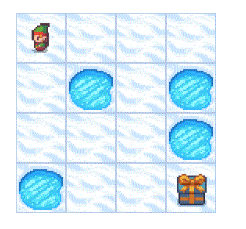

In [ ]:
def testModel(input_tensor,verbose=True):
  with torch.no_grad():
    logit = tiny_model(input_tensor)
    ouput=np.argmax(logit.cpu().numpy(), axis=2)
    print("Input:")
    if(verbose):
     print(array2text(input_tensor,actionNames=action_names,observationNames=observation_names)[1:])
    else:
     print(input_tensor[1:].numpy()) 
    print("Ouptut:")
    if(verbose):
      print(array2textShifted(ouput[0],actionNames=action_names,observationNames=observation_names))
    else:
      print(ouput[0])

In [ ]:
test_tensor=test_batch[0]
testModel(test_tensor,verbose=False)

In [ ]:
def ouputLogits(input_tensor):
  with torch.no_grad():
    logit = tiny_model(input_tensor)
    return logit.cpu().numpy()[0]

In [ ]:
ouputLogits

In [ ]:
def testModelIterative(input_tensor,iterations=1,print_iterations=False,verbose=False):
  with torch.no_grad():
    for i in range(iterations):
      logit = tiny_model(input_tensor)
      ouput=np.argmax(logit.cpu().numpy(), axis=2)
      if(print_iterations):
        print("Ouptut_iteration"+str(i)+":")
        if(verbose):
          print(array2text(input_tensor,actionNames=action_names,observationNames=observation_names))
        else:
          print(input_tensor)
      input_tensor=torch.cat((input_tensor,torch.tensor([ouput[0,-1]])))
  print("Full_Output"+":")
  if(verbose):
    print(array2text(input_tensor,actionNames=action_names,observationNames=observation_names))
  else:
    print(input_tensor)
  return input_tensor


In [ ]:
def generateModelIterative(input_tensor,iterations=1,print_full=True,print_iterations=False,verbose=False):#TODO maybe make a variable in previous
  with torch.no_grad():
    for i in range(iterations):
      logit = tiny_model(input_tensor)
      ouput=np.argmax(logit.cpu().numpy(), axis=2)
      input_tensor=torch.cat((input_tensor,torch.tensor([ouput[0,-1]])))
  return input_tensor

In [ ]:
testModelIterative(torch.as_tensor([1]),iterations=60,verbose=True)

In [ ]:
testModelIterative(torch.as_tensor([0]),iterations=60,verbose=True)

In [ ]:
with torch.no_grad(): 
  input = torch.as_tensor(batch)
  logit = tiny_model(input)
  ouput=np.argmax(logit.cpu().numpy(), axis=2)
  print(array2text(batch[0],actionNames=action_names,observationNames=observation_names)[1:])
  print(array2textShifted(ouput[0],actionNames=action_names,observationNames=observation_names))

In [ ]:
with torch.no_grad():
  for i in range(10):
    random_tokens = torch.as_tensor(np.random.randint(10, size=30))
    testModel(random_tokens)
    

In [ ]:
with torch.no_grad():
  for i in range(10):
    random_tokens = torch.as_tensor(np.random.randint(10, size=6))
    testModel(random_tokens)
  

#Playing

In [ ]:
def gymEnvTransformer(env,model,max_step=10,reward2go=None,renderize=False, fps=60):
  if renderize:
     env = Recorder(env, './video', fps=fps)   
  obs=env.reset()
  steps=[0,obs]#Something weird about this
  if reward2go is not None:
    steps[0]= reward2go


  for j in range(max_step):
    np.argmax(logit.cpu().numpy(), axis=2)#TODO maybe sample probability instead
    actionlogits = model(encode_sequence([steps]))
    action=np.argmax(actionlogits.cpu().numpy(), axis=2)[0,-1]
    steps.append(action)
    obs, reward, done, info = env.step(action)

    if reward2go is not None:
      reward2go=reward2go-reward#TODO this migth crash if rtgo goes to 0
      steps.append(reward2go)
    else:
      steps.append(reward)
    steps.append(obs)
  if renderize:
    env.close()
    env.play()
  return steps

In [ ]:
with torch.no_grad():
    test_play_sequence=gymEnvTransformer(env,tiny_model,max_step=20,reward2go=0)#,render=True
print(test_play_sequence)
print(array2text(test_play_sequence,actionNames=action_names,observationNames=observation_names))
printActions(test_play_sequence, actionNames=action_names)

In [ ]:
#env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
#gymEnvSample(env)#,render=True TODO fix

#Existing experiemnts

##Utils

In [ ]:
tokens_test= [0,0,0,0,0,0,0,0,0,0]

##Visualising attention patterns

In [ ]:
for layer in range(tiny_model.cfg.n_layers):
  for head in range(tiny_model.cfg.n_heads):
    imshow(to_numpy(tiny_cache[f'blocks.{layer}.attn.hook_attn'].mean(0)[head]), title=f'Layer {layer} Attention Pattern, Head {head}', height=500, width=500, xaxis="Token", yaxis="Activation")

In [ ]:
%%capture
# Install an older version of node, so that Svelte works (a web dev framework)
!curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
!pip install git+https://github.com/neelnanda-io/PySvelte.git
import sys
sys.path.append('/content/PySvelte')

In [ ]:
def cache_model(test_tokens):#TODO use model as imput
  with torch.no_grad():
    test_tokens_str=array2text(test_tokens,actionNames=action_names,observationNames=observation_names)
    logits, tiny_cache = tiny_model.run_with_cache(test_tokens)
    highest_logit = np.argmax(logits.cpu().numpy(), axis=2)
    print(f"Output tokens:{highest_logit}") 
    return test_tokens_str,logits, tiny_cache


In [ ]:
test_tokens=torch.as_tensor([1,0,1,0,5,0,1,0,0])
test_tokens_str,logits, tiny_cache=cache_model(test_tokens)

In [ ]:
import pysvelte
def attention_visualization(model):
  for layer in range(model.cfg.n_layers):
    print("Attention for layer", layer)
    print(tiny_cache[f'blocks.{layer}.attn.hook_attn'][0].shape)
    pysvelte.AttentionMulti(attention=tiny_cache[f'blocks.{layer}.attn.hook_attn'][0].permute(1, 2, 0),tokens=test_tokens_str).show() #.attn.hook_attn']

In [ ]:
print(test_batch[1])

In [ ]:
test_tokens=torch.as_tensor([ 1,  0,  1,  1,  4,  1,  1,  8,  2,  1,  9,  2,  1, 10,  1,  1, 14,  2,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1])
test_tokens_str,logits, tiny_cache=cache_model(test_tokens)
attention_visualization(tiny_model)

In [ ]:
#TODO make function to do this more easily
for i in reversed(range(16)):
  attention_score=tiny_cache[f'blocks.{layer}.attn.hook_attn'][0].permute(1, 2, 0)[17*3,i*3+1]#[source target]
  print(f'Step{str(i).zfill(2)} Attention_Score={attention_score.item():.4f}')

In [ ]:
#TODO make function to do this more easily
for i in range(16):
  attention_score=tiny_cache[f'blocks.{layer}.attn.hook_attn'][0].permute(1, 2, 0)[i*3+1,0*3+1]#[source target]
  print(f'Step{str(i).zfill(2)} Attention_Score={attention_score.item():.4f}')

##Direct logit atribution
###Neels explanation

The residual stream is the sum of the output of each layer, so we can map each layer output to a set of logits, and look at the contribution to the logit diff to figure out how much it contributes.

Further, as the output of the attn layer is the sum of each head (plus a bias term), we can look at each head's contribution.

This is called the direct logit attribution - direct since we're looking at the logits, so there's just a linear map (holding layernorm scale fixed) (Exercise: Why is this not direct if we're looking at the loss or log probs?)

We can calculate this more efficiently by dotting with W_U[John] - W_U[Mary], which just a direction in the residual stream

In [ ]:
test_tokens=torch.as_tensor([1,0,1,0,5,0,1,0,0])
#TODO modify this to work here (still probably has bugs)

# Set use attn result to True - this gives us a hook for the result of each head, 
# ie the d_model length vectors whose sum makes up attn_out and is added to the residual stream
tiny_model.cfg.use_attn_result = True

logit_diff_direction = tiny_model.unembed.W_U[:, 0]
# Take the scaling factor of the layernorm pre-unembed on the final token, so our logit attrs are on the same scale
final_layer_norm_scale = (tiny_cache['ln_final.hook_scale'][0, -1])
print("Final layer norm scaling factor:", final_layer_norm_scale.item())

direct_logit_attr = torch.zeros(tiny_model.cfg.n_layers, tiny_model.cfg.n_heads).to(device)
def calc_direct_logit_attr(result, hook):
    layer = int(hook.name.split('.')[1])
    final_token_result = result[0, -1]
    direct_logit_attr[layer] = (final_token_result @ (logit_diff_direction))/final_layer_norm_scale

tiny_model.run_with_hooks(test_tokens, fwd_hooks = [(lambda name:name.endswith('hook_result'), calc_direct_logit_attr)])

imshow(direct_logit_attr, xaxis='Head', yaxis='Layer', title='Direct Logit Attribution')

# Switch use_attn_result back off, since it consumes a lot of memory (Exercise: Why is this more expensive than eg calculating the value?)
tiny_model.cfg.use_attn_result = False

##Ablating layers

In [ ]:
def get_logit_probability(logits):
    # Takes in a batch x position x vocab tensor of logits, and returns the difference between the John and Mary logit
    return F.softmax(logits,dim=-1)[0, -1, 0]
example_tokens_tensor= torch.tensor(tokens_test)    
example_logits = tiny_model(example_tokens_tensor) # Shape batch x position x vocab
example_logit_diff = get_logit_probability(example_logits)
print(f"Input text: {tokens_test}, : {example_logit_diff.item()}")    

In [ ]:
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    # Helper function to plot multiple lines
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()

In [ ]:
def ablate_layer_hook(layer_out, hook):
    layer_out[:] = 0.
    return layer_out
attn_ablation = []
example_tokens_tensor= torch.tensor(tokens_test)
for layer in range(tiny_model.cfg.n_layers):
    logits = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_attn_out", ablate_layer_hook)])
    ablated_logit_diff = get_logit_probability(logits)
    change_in_logit_diff = ablated_logit_diff - example_logit_diff #Negative = strong effect
    attn_ablation.append((change_in_logit_diff.item()))
mlp_ablation = []
for layer in range(tiny_model.cfg.n_layers):
    logits = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_mlp_out", ablate_layer_hook)])
    ablated_logit_diff = get_logit_probability(logits)
    change_in_logit_diff = ablated_logit_diff - example_logit_diff #Negative = strong effect
    mlp_ablation.append((change_in_logit_diff.item()))
lines([attn_ablation, mlp_ablation], labels=['attn', 'mlp'], title='Layer Ablations', yaxis='Change in logit_prob', xaxis='Layer')
print("attention ablation:" +str(attn_ablation))
print("mlp ablation:"+str(mlp_ablation))

In [ ]:
#TODO 1 layer ablation

##Test outputs

##Ablating Heads

In [ ]:
def get_logit_probability(logits):#TODO maybe actual logit instead or separately since this doesnt help us dinstinghuish between teducing the ouput of this and increasing the ouputs of the other tokens
    #return F.softmax(logits,dim=-1)[0, -1, 0]#version for fist logit
    return F.softmax(logits,dim=-1)[0, -1, -1]#TODo mayeb get average or something instead of last logit
example_tokens_tensor= torch.tensor(tokens_test)    
example_logits = tiny_model(example_tokens_tensor) # Shape batch x position x vocab
example_logit_probability = get_logit_probability(example_logits)
print(f"Input text: {tokens_test}, : {example_logit_diff.item()}")

In [ ]:
def ablate_head_hook(value, hook, head_index):
    # Shape of value: batch x position x head_index x d_head
    value[:, :, head_index] = 0
    return value
head_ablation = torch.zeros((tiny_model.cfg.n_layers, tiny_model.cfg.n_heads))
example_tokens_tensor= torch.tensor(tokens_test)
for layer in tqdm.tqdm(range(tiny_model.cfg.n_layers)):
    for head_index in range(tiny_model.cfg.n_heads):
        logits = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.attn.hook_v", partial(ablate_head_hook, head_index=head_index))])
        ablated_logit = get_logit_probability(logits)
        change_in_logit = ablated_logit- example_logit_probability #Negative = strong effect
        head_ablation[layer, head_index]=((change_in_logit))
imshow(head_ablation, title='Effect of ablating each head', xaxis='Head', yaxis='Layer')
print(logits[0,0])
print(example_logits[0,0])

In [ ]:
print(logits)

In [ ]:
#TODO show ouputs after ablating head


##Ablating attention

In [ ]:
#Todo ablate all attention heads and not the mkp


In [ ]:
#Test visualize ablation 
imshow(tiny_model.blocks[0].attn.W_Q[0], title=f'Layer 0 Attention Query Weight, Head 0', height=500, width=500, xaxis="Token", yaxis="Activation")

##Looking at the atention matrix

In [ ]:
#check the names of the blocks
for name, param in tiny_model.named_parameters(): print(name, param.shape) 

###Convenient attention diagram to remember what all the weights mean:


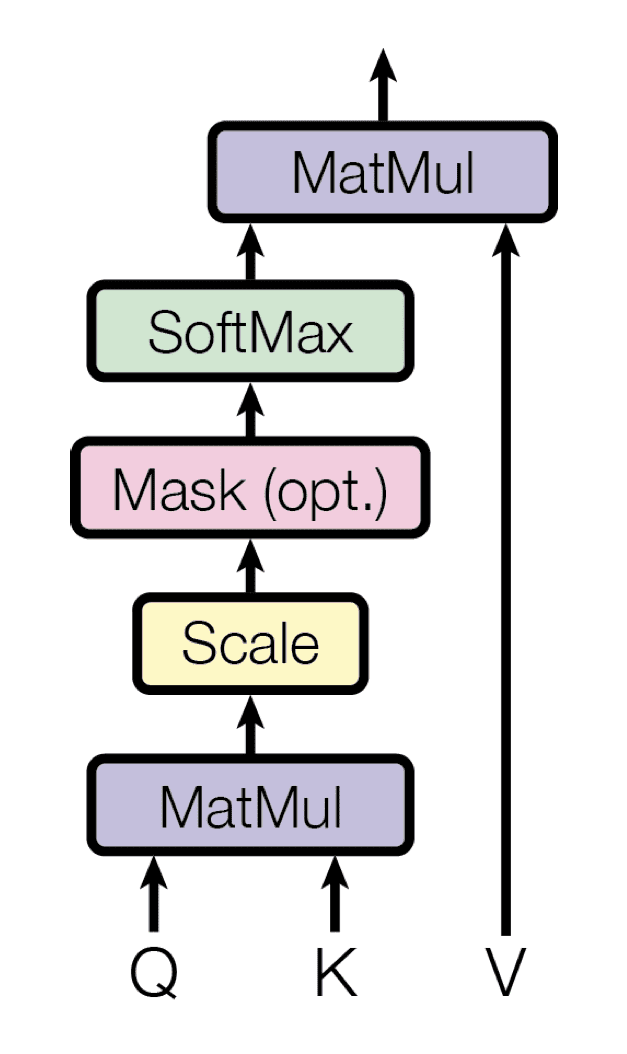


TODO maybe make/find a better diagram whith the weigths

##Visualizing the  weights 

In [ ]:
for layer in range(tiny_model.cfg.n_layers): #TODO figure out what to call axis.
  for head in range(tiny_model.cfg.n_heads):
    imshow(tiny_model.blocks[layer].attn.W_Q[head], title=f'Layer {layer} Attention Query Weight, Head {head}', height=500, width=500, xaxis="Token", yaxis="Activation")
    print(f'Layer {layer} Attention Query Bias, Head {head}: {tiny_model.blocks[layer].attn.b_Q}')
    imshow(tiny_model.blocks[layer].attn.W_K[head], title=f'Layer {layer} Attention Key Weight, Head {head}', height=500, width=500, xaxis="Token", yaxis="Activation")
    print(f'Layer {layer} Attention Key Bias, Head {head}: {tiny_model.blocks[layer].attn.b_K}')
    imshow(tiny_model.blocks[layer].attn.W_V[head], title=f'Layer {layer} Attention Value Weight, Head {head}', height=500, width=500, xaxis="Token", yaxis="Activation")
    print(f'Layer {layer} Attention Value Bias, Head {head}: {tiny_model.blocks[layer].attn.b_V}')
    imshow(tiny_model.blocks[layer].attn.W_O[head], title=f'Layer {layer} Attention Ouput Weight, Head {head}', height=500, width=500, xaxis="Token", yaxis="Activation")
    print(f'Layer {layer} Attention Ouput Bias, Head {head}: {tiny_model.blocks[layer].attn.b_O}')
  imshow(tiny_model.blocks[layer].mlp.W_in, title=f'Layer {layer} MLP Input Weight, Head {head}', height=500, width=500, xaxis="Token", yaxis="Activation")
  print(f'Layer {layer} MLP  Imput Bias, Head {head}: {tiny_model.blocks[layer].mlp.b_in}')
  imshow(tiny_model.blocks[layer].mlp.W_out, title=f'Layer {layer} MLP Output Weight, Head {head}', height=500, width=500, xaxis="Token", yaxis="Activation")
  print(f'Layer {layer} MLP Output Bias: {tiny_model.blocks[layer].mlp.b_out}')
  print(f'Layer {layer} MLP layer norm: {tiny_model.blocks[layer].mlp.ln}')
  print(f'Layer {layer} MLP layerNorm Bias: {head} {tiny_model.blocks[layer].mlp.ln.b}')


###Encoder weigths

In [ ]:
imshow(tiny_model.embed.W_E, title="Token embedding", height=500, width=500, xaxis="Token", yaxis="Activation")
imshow(tiny_model.pos_embed.W_pos, title="Positional embedding", height=500, width=500, xaxis="Token", yaxis="Activation")


In [ ]:
def get_token_encoding(tokenID,position=None):#Ouputs the 
  with torch.no_grad():
   encoding = tiny_model.embed.W_E[tokenID]
   if position is not None:
      encoding= encoding + tiny_model.pos_embed.W_pos[position]
   return encoding 

print(get_token_encoding(0))
print(get_token_encoding(0,1))

In [ ]:
#check the names of the blocks
for name, param in tiny_model.named_parameters(): print(name, param.shape) 

###Unembed

In [ ]:
imshow(tiny_model.unembed.W_U.T, title="Unembed weights", height=500, width=500, xaxis="Embedding Component", yaxis="Token")
print(f'Unembed bias: {tiny_model.unembed.b_U}')

In [ ]:
originX = np.zeros(10) # origin point
originY = np.zeros(10) # origin point
colors = ['r', 'b', 'b', 'b','b', 'b', 'b','b', 'b', 'b']

print(tiny_model.unembed.W_U.t().shape)
print(tiny_model.embed.W_E.t().cpu().detach().numpy()[1].shape)
plt.quiver(originX,originY,tiny_model.embed.W_E.t().cpu().detach().numpy()[0],tiny_model.embed.W_E.t().cpu().detach().numpy()[1],scale=5,color=colors)

plt.show()
originX = np.zeros(6) # origin point
originY = np.zeros(6) # origin point
plt.quiver(originX,originY,tiny_cache["hook_embed"][0,:,0].cpu(),tiny_cache["hook_embed"][0,:,1].cpu(),scale=5,color=colors)
plt.show()

In [ ]:
tokens_test=torch.as_tensor([5, 0, 7, 1, 0,0])
test_tokens_str,logits, tiny_cache=cache_model(tokens_test)


In [ ]:
imshow(tiny_cache["blocks.0.hook_resid_pre"][0])

In [ ]:
imshow(tiny_cache["blocks.0.hook_resid_mid"][0])

In [ ]:
imshow(tiny_cache["ln_final.hook_normalized"][0])

In [ ]:
imshow(tiny_cache["ln_final.hook_scale"][0])

In [ ]:
imshow(tiny_cache["blocks.0.hook_mlp_out"][0])

#Test miscelaneos

In [ ]:
for i in range(16):
  print(generateModelIterative(torch.as_tensor([ 0,  i]),iterations=58))

#print(testModelIterative(torch.as_tensor([ 0,  i]),iterations=10,verbose=True))


In [ ]:
for i in range(16):
  print(generateModelIterative(torch.as_tensor([ 1,  i]),iterations=10))


In [ ]:
for i in range(16):
  print(array2text(generateModelIterative(torch.as_tensor([ 1,  i]),iterations=10),observationNames=observation_names,actionNames=action_names)[1:3])

In [ ]:
for i in range(16):
  print(str(i)+" "+array2text(generateModelIterative(torch.as_tensor([ 1,  i]),iterations=10),observationNames=observation_names,actionNames=action_names)[4])

In [ ]:
for i in range(16):
  print(array2text(generateModelIterative(torch.as_tensor([ 0,  i]),iterations=58),observationNames=observation_names,actionNames=action_names))

In [ ]:
  print(array2text(generateModelIterative(torch.as_tensor([ 0,  11]),iterations=58),observationNames=observation_names,actionNames=action_names))

## Temp tests

In [ ]:
testModelIterative(torch.as_tensor([ 0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10, 1, 1, 14, 2,0, 15,  1]),iterations=5,verbose=True)
#testModelIterative(torch.as_tensor([ 0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10, 1, 1, 14, 2,0, 15,  1]),iterations=5,verbose=True)
testModelIterative(torch.as_tensor([ 0,  5]),iterations=20,verbose=True)

In [ ]:
for i in range(16):
  print(generateModelIterative(torch.as_tensor([ 1,  i]),iterations=10))

In [ ]:
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
gymEnvSample(env,renderize=True)